# Lab 05_1: Coupled Mode Network Theory

### developed by Seong Hyeon Park (pajoheji0909@snu.ac.kr)

### Please find the attached homework at the end of this tutorial code

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# this cell should be commented if you load Qiskit-Metal package
%matplotlib inline

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from numpy.linalg import inv
from sympy import Symbol
from sympy.solvers import solve
from IPython.display import display, Markdown

From the input-output theory, the equation of motion of an arbitrary linear coupled-mode system can be written as 

$\frac{d}{dt}a_j=\dot{a}_j=-i(\omega_j-i\frac{\gamma_i}{2})a_j-i\sum_{k\neq j}c_{jk}(a_k+a^*_k)+\sqrt{\gamma^\mathrm{ext}_j}a^\mathrm{in}_j$,

where $a_j$ is the amplitude of mode $j$, $\omega_j$ is the angular frequency of mode $j$, $\gamma_j=\gamma^\mathrm{int}_j+\gamma^\mathrm{ext}_j$ is the sum of mode's dissipation and $c_{jk}$ is the coupling rate between modes $j$ and $k$.

For coupled-mode system of $N$ modes, we can write the internal mode amplitudes as a vector $\vec{v}={a_j[\omega^s_j]}$ and $\omega^s_j$ is the signal frequency. Then, we can rewrite the equation of motion as follows:

$-i\gamma_0\bm{M}\vec{v}=\bm{K}\vec{v}_\mathrm{in}$,

where $\bm{K}=\mathrm{diag}(\sqrt{\gamma^\mathrm{ext}_j})$ is the external dissipation for all modes and $\bm{M}$ is 

$ \bm{M} = \begin{bmatrix}
\Delta_1 & \beta_{12} & \cdots & \beta_{1N} & \beta_{11*} & \cdots & \beta_{1N*} \\
\beta_{21} & \Delta_2 & \cdots & \beta_{2N} & \beta_{21*} & \cdots & \beta_{2N*} \\
\vdots &  & \ddots & \vdots & \vdots & \ddots & \vdots \\
\beta_{N1} & & \cdots & \Delta_N & \beta_{N1*} & \cdots & \beta_{NN*} \\
\beta_{1*1} & & \cdots & \beta_{1*N} & -\Delta*_1 & \cdots & \beta_{1*N*} \\
\vdots &  & \ddots & \vdots & \vdots & \ddots & \vdots \\
\beta_{N*1} & & \cdots & \beta_{N*N} & \beta_{N*1z*}  & \cdots & -\Delta*_N
\end{bmatrix}, $

where $\Delta_k = \frac{1}{\gamma_0}(\omega^s_k-\omega_k+i\frac{\gamma_k}{2})$ is the diagonal detuning term and $\beta_{jk} = \frac{c_{jk}}{2\gamma_0}$ is the off-diagonal coupling term, respectively. 

Assume the input and output drive amplitudes are $\vec{v}_\mathrm{in}$ and $\vec{v}_\mathrm{out}$, respectively. If $\vec{v}_\mathrm{in}$ and $\vec{v}_\mathrm{out}$ satisfy boundary conditions at each port, $\vec{v}_\mathrm{in}+\vec{v}_\mathrm{out}=\bm{K}\vec{v}$, the scattering matrix $\bm{S}$ in classical engineering (see lecture notes on microwave engineering) can be expressed as 

$\bm{S}=i\frac{1}{\gamma_0}\bm{K}\bm{M}^{-1}\bm{K}-\mathbb{I}$,

$S_{jk} = \frac{a^\mathrm{out}_j}{a^\mathrm{in}_k}=i\frac{\sqrt{\gamma^\mathrm{ext}_j\gamma^\mathrm{ext}_k}}{\gamma_0}[\bm{M}^{-1}]_{jk}-\delta_{jk}.$

For an amplifier design with gain $G$, the target equation in terms of $\bm{S}$ can be expressed as 

$S_{11}=\sqrt{G}.$

Reference: O Naaman and J Aumentado, "Synthesis of Parametrically Coupled Networks", *PRX Quantum*, **3**, 020201 (2022) DOI: https://doi.org/10.1103/PRXQuantum.3.020201

In [ ]:
# Coupled-Mode Network Theory for two-pole impedance transformer

def simulation_cmn(omega_0: float = 6.9e9*2*np.pi, bandwidth: float = 400e6*2*np.pi, shunt_c: float = 3.4e-12, Z_0: float = 50, 
                   g_list: np.array =np.array([1.0, 0.3184, 0.1982, 1.1055]), if_plot_SBA: bool = False):
        
    gamma_list = bandwidth/(g_list[-2]*g_list[-1]) 
    gamma_0 = gamma_list

    beta_list = list(map(lambda x: bandwidth/(2*gamma_0*np.sqrt(g_list[x]*g_list[x+1])), range(len(g_list)-1)))
    omega_A = omega_0; omega_B =omega_0; omega_pump = omega_0*2
    
    def equation_of_motion_PA(pole_number: int = None, signal_f: float = None):
        beta_PA = 1/2*(g_list[-2]*g_list[-1])/(g_list[0]*g_list[1])
        
        omega_signal = signal_f*2*np.pi
        M = np.zeros((2*pole_number, 2*pole_number), dtype=complex)
        for row_idx in range(len(M)):
            for col_idx in range(len(M[0])):
                # diagonal element
                if row_idx == col_idx:
                    if row_idx == 0:
                        gamma_A = bandwidth/(g_list[-2]*g_list[-1])
                        _delta_A = 1/gamma_0*(omega_signal-omega_A)+1j*gamma_A/(2*gamma_0)
                        M[row_idx][col_idx] = _delta_A
                    elif row_idx == len(M)-1:
                        gamma_B = bandwidth/(g_list[-2]*g_list[-1])
                        _delta_B = 1/gamma_0*(omega_signal-omega_pump+omega_B)+1j*gamma_B/(2*gamma_0)
                        M[row_idx][col_idx] = _delta_B 
                    else:
                        M[row_idx][col_idx] = 1/gamma_0*(omega_signal-omega_A)
                # lower off-diagonal (col-1 = row)
                elif row_idx == col_idx+1 and row_idx >= 0:
                    if row_idx < len(M)/2:
                        M[row_idx][col_idx] = beta_list[-row_idx-1]
                    elif row_idx == len(M)/2:
                        M[row_idx][col_idx] = -beta_PA
                    else:
                        M[row_idx][col_idx] = -beta_list[row_idx-len(M)-1]
                # upper off-diagonal (col+1 = row)
                elif row_idx == col_idx - 1 and row_idx <= len(M)-1:
                    if row_idx < len(M)/2-1:
                        M[row_idx][col_idx] = beta_list[-row_idx-2]
                    elif row_idx == len(M)/2-1:
                        M[row_idx][col_idx] = beta_PA
                    else:
                        M[row_idx][col_idx] = -beta_list[row_idx-len(M)]
        return M

    display(Markdown(rf"$\gamma$ are {np.array(gamma_list)/1e9/2/np.pi} GHz while $\gamma_0$ is {gamma_0/1e9/2/np.pi} GHz"))
    display(Markdown(rf"$\beta_{{i,i+1}}$ are {beta_list} "))
    display(Markdown(rf"$\beta_{{PA}}$ are { 1/2*(g_list[-2]*g_list[-1])/(g_list[0]*g_list[1])} "))
    print(equation_of_motion_PA(int(len(g_list)/2), omega_0/2/np.pi))
    S_AA = []; S_BA = []
    freq_sweep = np.linspace(omega_0/2/np.pi-700e6, omega_0/2/np.pi+700e6, 1001)

    for freq in freq_sweep:
        S_AA.append(1j*bandwidth/(g_list[-1]*g_list[-2])/gamma_0*inv(equation_of_motion_PA(int(np.ceil(len(g_list)/2)), freq))[0][0]-1)
        S_BA.append(1j*bandwidth/(g_list[-1]*g_list[-2])/gamma_0*inv(equation_of_motion_PA(int(np.ceil(len(g_list)/2)), freq))[int(np.ceil(len(g_list)/2))+1][0])

    fig, ax1 = plt.subplots(figsize=(10, 8))
    ax1.plot(freq_sweep/1e9, 20*np.log10(np.abs(S_AA)), label=r'$S_{AA}$', linewidth=3, color='magenta', linestyle ='-')
    if if_plot_SBA is True:
        ax1.plot(freq_sweep/1e9, 20*np.log10(np.abs(S_BA)), label=r'$S_{BA}$', linewidth=3, color='blue', linestyle ='--')
    
    ax1.grid(); ax1.tick_params(axis='both', which='major', labelsize=22)
    ax1.set_xlim([np.min(freq_sweep)/1e9, np.max(freq_sweep)/1e9]); ax1.set_ylim([-1, 25])
    ax1.set_xticks(np.arange(np.min(freq_sweep)/1e9, np.max(freq_sweep+1)/1e9, 0.2))
    ax1.set_xlabel("Signal frequency (GHz)", fontsize=24); ax1.set_ylabel("Gain (dB)", fontsize=24)

    # for two-pole impedance-transformed JPA
    if len(g_list) == 4:
        Z_p = 1/(omega_0*shunt_c); Z_ref = g_list[1]*omega_0/bandwidth*Z_p 
        Z_L = Z_ref/g_list[3]
        Z_ser = g_list[1]*g_list[2]*Z_p/(bandwidth/omega_0)**2
        J_prime = 1/np.sqrt(Z_L*Z_0)

        Z_quarter = 1/J_prime

        Z = Symbol('Z')
        coeff1 = -(2/np.pi*Z_ser-1/2*Z_quarter*(1-Z_quarter**2/Z_0**2)); const1 = -Z_quarter**4/Z_0**2
        solution = solve(Z**2 + coeff1*Z + const1, Z)

        display(Markdown(rf"Impedance of a SQUID-mode is $Z_\mathrm{{SQ}}={Z_p:.2f}$ $\Omega$ and the inductance is $L_\mathrm{{SQ}}={Z_p/(omega_0)/1e-12:.2F}$ pH"))
        display(Markdown(rf"For two-pole impedance transformer, converted $Z_{{\lambda/4}}={Z_quarter:.2f}$ $\Omega$ and converted $Z_{{\lambda/2}}={np.array([i for i in solution if i > 0])}$ $\Omega$ "))

To find the electrical circuit component values, we need to convert the quantum-mechanical coupling (and decay) rates into inductance $L$ and capacitance $C$. A well-known topology to broaden the gain bandwidth of a Josephson parametric amplifier is to employ an impedance transformer to match the impedance between a capacitively shunted SQUID and the environment (usually, $Z_0=50~\Omega$). This analysis is very similar to design and analysis of a parametric amplifier with negative resistance in microwave engineering. 

See G. L. Matthaei, "A study of the optimum design of wideband parametric amplifiers and up-converters", *IRE Trans. Microw. Theory Tech.*, **9**, 23-38 (1961). DOI: https://doi.org/10.1109/TMTT.1961.1125259

Below is a step-by-step analysis to convert an electrical circuit with prototype $L$ and $C$ into a two-pole impedance transformer.
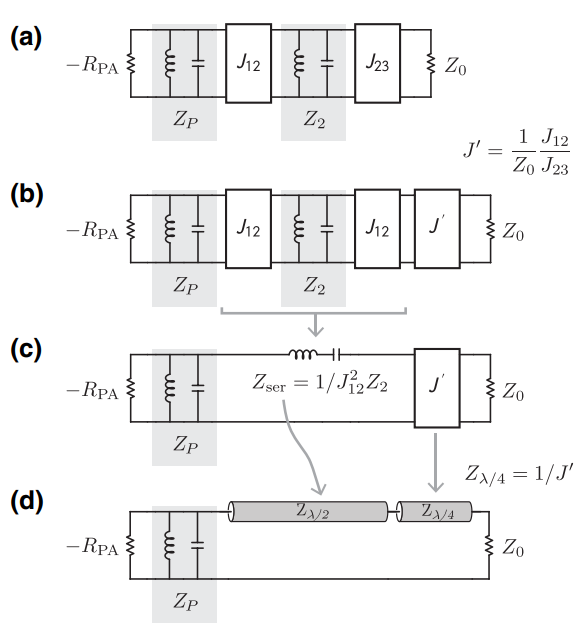

Reference: T Roy *et al.,* "Broadband parametric amplification with impedance engineering: Beyond the gain-bandwidth product," *Appl. Phys. Lett.,* **107**, 262601 (2015) DOI: https://doi.org/10.1063/1.4939148

In [ ]:
# example study: two-pole impedance-matched parametric amplifier
# circuit parameters from T Roy et al., Appl. Phys. Lett., 107, 262601 (2015)

omega_0 = 2*np.pi*6e9     # center frequency in [angular frequency]
bandwidth = 2*np.pi*600e6 # target bandwidth in [angular frequency]
C_s = 3.4e-12             # shunt capacitance of a lumped-JPA mode in [F]
Z_0 = 50                  # environmental impedance in [Ohm]
g_list = np.array([1.0, 0.4085, 0.2343, 1.1055]) # prototype coefficients (Butterworth) this array is for "two-pole amplifier" ONLY 

simulation_cmn(omega_0=omega_0, bandwidth=bandwidth, shunt_c=C_s, 
               g_list=g_list, Z_0=Z_0, if_plot_SBA=False)

Now you can design your own impedance-matched parametric amplifier! Note that the length of a resonator with $Z_{\lambda/4}$ should be half of that of a resonator with $Z_{\lambda/2}$ and the length, gap, center width of a CPW geometry should be accurately calculated.

In [ ]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength, lumped_cpw

# NOTE use SI units
# target resonant frequency
target_freq = 6e9

# film thickness of a CPW structure
film_thick = 200e-9

# width of a center conductor and gap of a CPW
cpw_width = 12e-6; cpw_gap = 9e-6

# dielectric constant and thickness of a substrate of a CPW
sub_eps_r = 11.45; sub_thick = 500e-6

# calculate the CPW parameters
full_wavelength, eff_const, filling_factor = guided_wavelength(freq=target_freq, 
                                                               line_width=cpw_width, line_gap=cpw_gap, 
                                                               substrate_thickness=sub_thick, film_thickness=film_thick, dielectric_constant=sub_eps_r)

print(f"assuming CPW width: {cpw_width/1e-6:.1f} um, CPW gap: {cpw_gap/1e-6:.1f} um, substrate dielectric constant: {sub_eps_r}")
print(f"for target frequency: {target_freq/1e9:.2f} GHz,")
print(f"half-wavelength: {full_wavelength/2/1e-3:.2f} mm, quarter-wavelength: {full_wavelength/4/1e-3:.2f} mm")

results_half = lumped_cpw(freq=target_freq,
                         line_width=cpw_width,
                         line_gap=cpw_gap,
                         substrate_thickness=sub_thick,
                         film_thickness=film_thick,
                         dielectric_constant=sub_eps_r,
                         loss_tangent=1e-9,                    # negligible
                         london_penetration_depth=1 * 10**-12) # negligible

print(f"assuming CPW width: {cpw_width/1e-6:.1f} um, CPW gap: {cpw_gap/1e-6:.1f} um, substrate dielectric constant: {sub_eps_r}")
print(f"the impedance of a half-CPW resonator is {results_half[4]:.2F} Ω")

In [ ]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength, lumped_cpw

# NOTE use SI units
# target resonant frequency
target_freq = 6e9

# film thickness of a CPW structure
film_thick = 200e-9

# width of a center conductor and gap of a CPW
cpw_width = 30e-6; cpw_gap = 6e-6

# dielectric constant and thickness of a substrate of a CPW
sub_eps_r = 11.45; sub_thick = 500e-6

# calculate the CPW parameters
full_wavelength, eff_const, filling_factor = guided_wavelength(freq=target_freq, 
                                                               line_width=cpw_width, line_gap=cpw_gap, 
                                                               substrate_thickness=sub_thick, film_thickness=film_thick, dielectric_constant=sub_eps_r)

print(f"assuming CPW width: {cpw_width/1e-6:.1f} um, CPW gap: {cpw_gap/1e-6:.1f} um, substrate dielectric constant: {sub_eps_r}")
print(f"for target frequency: {target_freq/1e9:.2f} GHz,")
print(f"half-wavelength: {full_wavelength/2/1e-3:.2f} mm, quarter-wavelength: {full_wavelength/4/1e-3:.2f} mm")

results_quarter = lumped_cpw(freq=target_freq,
                             line_width=cpw_width,
                             line_gap=cpw_gap,
                             substrate_thickness=sub_thick,
                             film_thickness=film_thick,
                             dielectric_constant=sub_eps_r,
                             loss_tangent=1e-9,                    # negligible
                             london_penetration_depth=1 * 10**-12) # negligible

print(f"assuming CPW width: {cpw_width/1e-6:.1f} um, CPW gap: {cpw_gap/1e-6:.1f} um, substrate dielectric constant: {sub_eps_r}")
print(f"the impedance of a quarter-CPW resonator is {results_quarter[4]:.2F} Ω")

# Design your impedance-matched parametric amplifiers using Qiskit-Metal!